# State Punishment Analysis Notebook
# ===================================

This notebook provides tools for analyzing TensorBoard results from state punishment experiments.
It includes data processing, visualization, and statistical analysis functions.

## Table of Contents
1. [Imports and Dependencies](#1-imports-and-dependencies)
2. [TensorBoard Data Processing](#2-tensorboard-data-processing)
3. [Data Analysis Utilities](#3-data-analysis-utilities)
4. [Visualization Functions](#4-visualization-functions)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Data Processing Pipeline](#6-data-processing-pipeline)
7. [Example Analysis](#7-example-analysis)


## 1. Imports and Dependencies


In [2]:
# Core data processing and visualization
from scipy.stats import zscore

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import time
from collections import defaultdict

# TensorFlow for TensorBoard processing
import tensorflow as tf
from tensorflow.python.framework.errors_impl import DataLossError

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All imports successful!")


/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_han

All imports successful!


## 2. TensorBoard Data Processing


In [2]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Step', 'Tag', 'Value'])
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [3]:
def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file to separate CSV files for each metric.
    
    Args:
        event_file (str): Path to the TensorBoard event file
        output_dir (str): Directory where CSV files should be saved
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")


In [4]:
def is_file_stable(file_path, wait_time=1.0):
    """Check if a file is stable (not being written to)."""
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Process all TensorBoard files in a directory structure.
    
    Args:
        parent_dir (str): Parent directory containing TensorBoard event files
        output_parent_dir (str): Parent directory where CSV files should be saved
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")


## 3. Data Analysis Utilities


In [5]:
# define a rolling window correlation function
from scipy.stats import pearsonr

def check_percentage_of_above_threshold(array, threshold, prop):
    proportion = np.mean(array > threshold)
    if proportion >= prop:
        return 1
    elif np.mean(array < threshold) >= prop:
        return -1
    else:
        return 0

def rolling_window_correlation(x, y, window):
    """
    Calculate the rolling window correlation and p-value between two 1D arrays.

    Args:
        x (array-like): First time series.
        y (array-like): Second time series.
        window (int): Window size for rolling correlation.

    Returns:
        tuple: (corrs, pvals)
            corrs: np.ndarray of correlation coefficients, length = len(x) - window + 1
            pvals: np.ndarray of p-values, same length
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if window < 1 or window > len(x):
        raise ValueError("Window size must be between 1 and the length of the input arrays.")

    corrs = []
    pvals = []
    prop =[]
    for i in range(len(x) - window + 1):
        x_win = x[i:i+window]
        y_win = y[i:i+window]
        # Remove nan pairs
        mask = ~np.isnan(x_win) & ~np.isnan(y_win)
        if np.sum(mask) < 2:
            corrs.append(np.nan)
            pvals.append(np.nan)
            prop.append(np.nan)
        else:
            r, p = pearsonr(x_win[mask], y_win[mask])
            corrs.append(r)
            pvals.append(p)
            prop.append(check_percentage_of_above_threshold(x_win[mask], 0.3, 0.6))
    return np.array(corrs), np.array(pvals), np.array(prop)



In [6]:
def trim_and_calculate_mean(array_list):
    """
    Trim arrays to the same length and calculate mean.
    
    Args:
        array_list: List of arrays to process
        
    Returns:
        numpy.ndarray: Array of trimmed arrays
    """
    min_length = min(len(arr) for arr in array_list)
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    return np.array(trimmed_arrays)

def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data
        alpha (float): The smoothing factor (0 < alpha <= 1)

    Returns:
        numpy.ndarray: The EMA values
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data
        window_size (int): The size of the rolling window

    Returns:
        numpy.ndarray: The rolling average values
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')


## 4. Visualization Functions


In [7]:
def plot_average_trajectory(time_series, error_type='std', time_points=None, 
                           xlabel='Time', ylabel='Value', title='Average Trajectory'):
    """
    Plot the average trajectory of a set of time series with error bars.

    Parameters:
    - time_series (2D array-like): A set of time series, shape (n_series, n_time_points)
    - error_type (str): Either 'std' for standard deviation or 'sem' for standard error
    - time_points (1D array-like, optional): Time points corresponding to the time series
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    - title (str): Title of the plot
    """
    time_series = np.array(time_series)
    if time_points is None:
        time_points = np.arange(time_series.shape[1])
    else:
        time_points = np.array(time_points)
    
    if time_series.shape[1] != len(time_points):
        raise ValueError("Length of time_points must match the number of columns in time_series.")
    
    # Compute average and error
    mean_trajectory = np.mean(time_series, axis=0)
    if error_type == 'std':
        error = np.std(time_series, axis=0)
    elif error_type == 'sem':
        error = np.std(time_series, axis=0) / np.sqrt(time_series.shape[0])
    else:
        raise ValueError("error_type must be 'std' or 'sem'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory', color='blue')
    plt.fill_between(time_points, mean_trajectory - error, mean_trajectory + error, 
                     alpha=0.3, color='blue', label='Error')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_multiple_conditions(data_list, labels, window_size=200, title="Comparison"):
    """
    Plot multiple conditions with rolling average smoothing.
    
    Args:
        data_list: List of data arrays for each condition
        labels: List of labels for each condition
        window_size: Window size for rolling average
        title: Plot title
    """
    plt.figure(figsize=(12, 6))
    
    for i, (data, label) in enumerate(zip(data_list, labels)):
        if len(data) > window_size:
            smoothed = rolling_average(data, window_size)
            plt.plot(smoothed, label=label, alpha=0.8)
        else:
            plt.plot(data, label=label, alpha=0.8)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## 5. Statistical Analysis


In [8]:
def coefficient_of_variation(timestamps):
    """
    Calculate the coefficient of variation (CV) of inter-visit intervals.
    
    Parameters:
    - timestamps: A list or array of timestamps representing the times of visits or events
    
    Returns:
    - CV: The coefficient of variation (standard deviation / mean) of inter-visit intervals
    """
    inter_visit_intervals = np.diff(timestamps)
    mean_interval = np.mean(inter_visit_intervals)
    std_dev_interval = np.std(inter_visit_intervals)
    cv = std_dev_interval / mean_interval
    return cv

def fourier_transform_periodicity(data):
    """
    Perform a Fourier Transform to find the dominant frequency and quantify periodicity.
    
    Parameters:
    - data: A list or array representing the time series data
    
    Returns:
    - dominant_period: The period corresponding to the dominant frequency
    - power_at_dominant_frequency: The strength of the dominant frequency
    """
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data))
    power = np.abs(fft_result)
    
    dominant_frequency = frequencies[np.argmax(power)]
    dominant_period = 1 / dominant_frequency
    
    return dominant_period, power[np.argmax(power)]

def correlation_analysis(x, y, method='spearman'):
    """
    Perform correlation analysis between two variables.
    
    Args:
        x, y: Arrays to correlate
        method: 'pearson' or 'spearman'
        
    Returns:
        correlation coefficient and p-value
    """
    if method == 'pearson':
        return pearsonr(x, y)
    elif method == 'spearman':
        return spearmanr(x, y)
    else:
        raise ValueError("Method must be 'pearson' or 'spearman'")

def multiple_regression_analysis(data_dict, target_var):
    """
    Perform multiple regression analysis.
    
    Args:
        data_dict: Dictionary with variable names as keys and arrays as values
        target_var: Name of the target variable
        
    Returns:
        Dictionary with regression results
    """
    df = pd.DataFrame(data_dict)
    
    # Separate features and target
    feature_vars = [col for col in df.columns if col != target_var]
    X = df[feature_vars]
    y = df[target_var]
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        'intercept': model.intercept_,
        'coefficients': dict(zip(feature_vars, model.coef_)),
        'mse': mse,
        'r2': r2
    }


## 6. Data Processing Pipeline


In [9]:
def load_experiment_data(folders, entity_names, agent_filter=None):
    """
    Load and process data from multiple experiment folders.
    
    Args:
        folders: List of experiment folder names
        entity_names: List of entity/metric names to load
        agent_filter: Optional filter for specific agents (e.g., 'Agent_0')
        
    Returns:
        Dictionary with processed data for each folder and entity
    """
    results = {}
    
    for folder in folders:
        results[folder] = {}
        parent_dir = os.path.join('res', folder)
        
        if not os.path.exists(parent_dir):
            print(f"Warning: Directory {parent_dir} does not exist")
            continue
            
        files = os.listdir(parent_dir)
        
        for entity_name in entity_names:
            entity_data = []
            
            for f in files:
                if entity_name in f:
                    if agent_filter is None or agent_filter in f:
                        file_path = os.path.join(parent_dir, f)
                        try:
                            data = pd.read_csv(file_path)
                            entity_data.append(data['Value'].to_numpy())
                        except Exception as e:
                            print(f"Error reading {file_path}: {e}")
            
            if entity_data:
                # Calculate mean across runs
                processed_data = np.mean(trim_and_calculate_mean(entity_data), axis=0)
                results[folder][entity_name] = processed_data
            else:
                print(f"No data found for {entity_name} in {folder}")
    
    return results

def compare_conditions(data_dict, metric_name, labels=None, window_size=200):
    """
    Compare a specific metric across different conditions.
    
    Args:
        data_dict: Dictionary with experiment data
        metric_name: Name of the metric to compare
        labels: Optional labels for conditions
        window_size: Window size for smoothing
    """
    data_list = []
    condition_labels = []
    
    for folder, metrics in data_dict.items():
        if metric_name in metrics:
            data_list.append(metrics[metric_name])
            condition_labels.append(folder if labels is None else labels[len(data_list)-1])
    
    if data_list:
        plot_multiple_conditions(data_list, condition_labels, window_size, f"{metric_name} Comparison")
    else:
        print(f"No data found for metric: {metric_name}")


## 7. Example Analysis


In [119]:
# Example: Process TensorBoard results
# Uncomment and modify paths as needed

parent_dir = '../runs_no_exploration/' # runs_p48
output_dir = 'res/runs_no_exploration/' # res/runs_p48_a2_deterministic
process_tensorboard_results(parent_dir, output_dir)


Data for tag 'loss' has been written to res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251103-160819/loss_data.csv
Data for tag 'score' has been written to res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251103-160819/score_data.csv
Data for tag 'epsilon' has been written to res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251103-160819/epsilon_data.csv
Data for tag 'Agent_0/individual_score' has been written to res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251103-160819/Agent_0_individual

In [ ]:
# Example: Load and analyze experiment data

# Define experiment folders
example_folders = [
    'experiment_1',
    'experiment_2', 
    'experiment_3'
]

# Define metrics to analyze
metrics = ['Reward', 'Loss', 'Epsilon']

# Load data
# experiment_data = load_experiment_data(example_folders, metrics)

# Compare rewards across conditions
# compare_conditions(experiment_data, 'Reward', 
#                   labels=['Condition 1', 'Condition 2', 'Condition 3'])

print("Example analysis functions ready. Uncomment and modify as needed.")


In [ ]:
# Example: Statistical analysis

# Generate example data for demonstration
np.random.seed(42)
x = np.random.randn(1000)
y = 2 * x + np.random.randn(1000) * 0.5

# Correlation analysis
corr_coef, p_value = correlation_analysis(x, y, method='pearson')
print(f"Pearson correlation: {corr_coef:.3f}, p-value: {p_value:.3e}")

# Multiple regression example
example_data = {
    'X1': x,
    'X2': np.random.randn(1000),
    'Y': y
}

regression_results = multiple_regression_analysis(example_data, 'Y')
print(f"\nRegression Results:")
print(f"R²: {regression_results['r2']:.3f}")
print(f"MSE: {regression_results['mse']:.3f}")
print(f"Coefficients: {regression_results['coefficients']}")


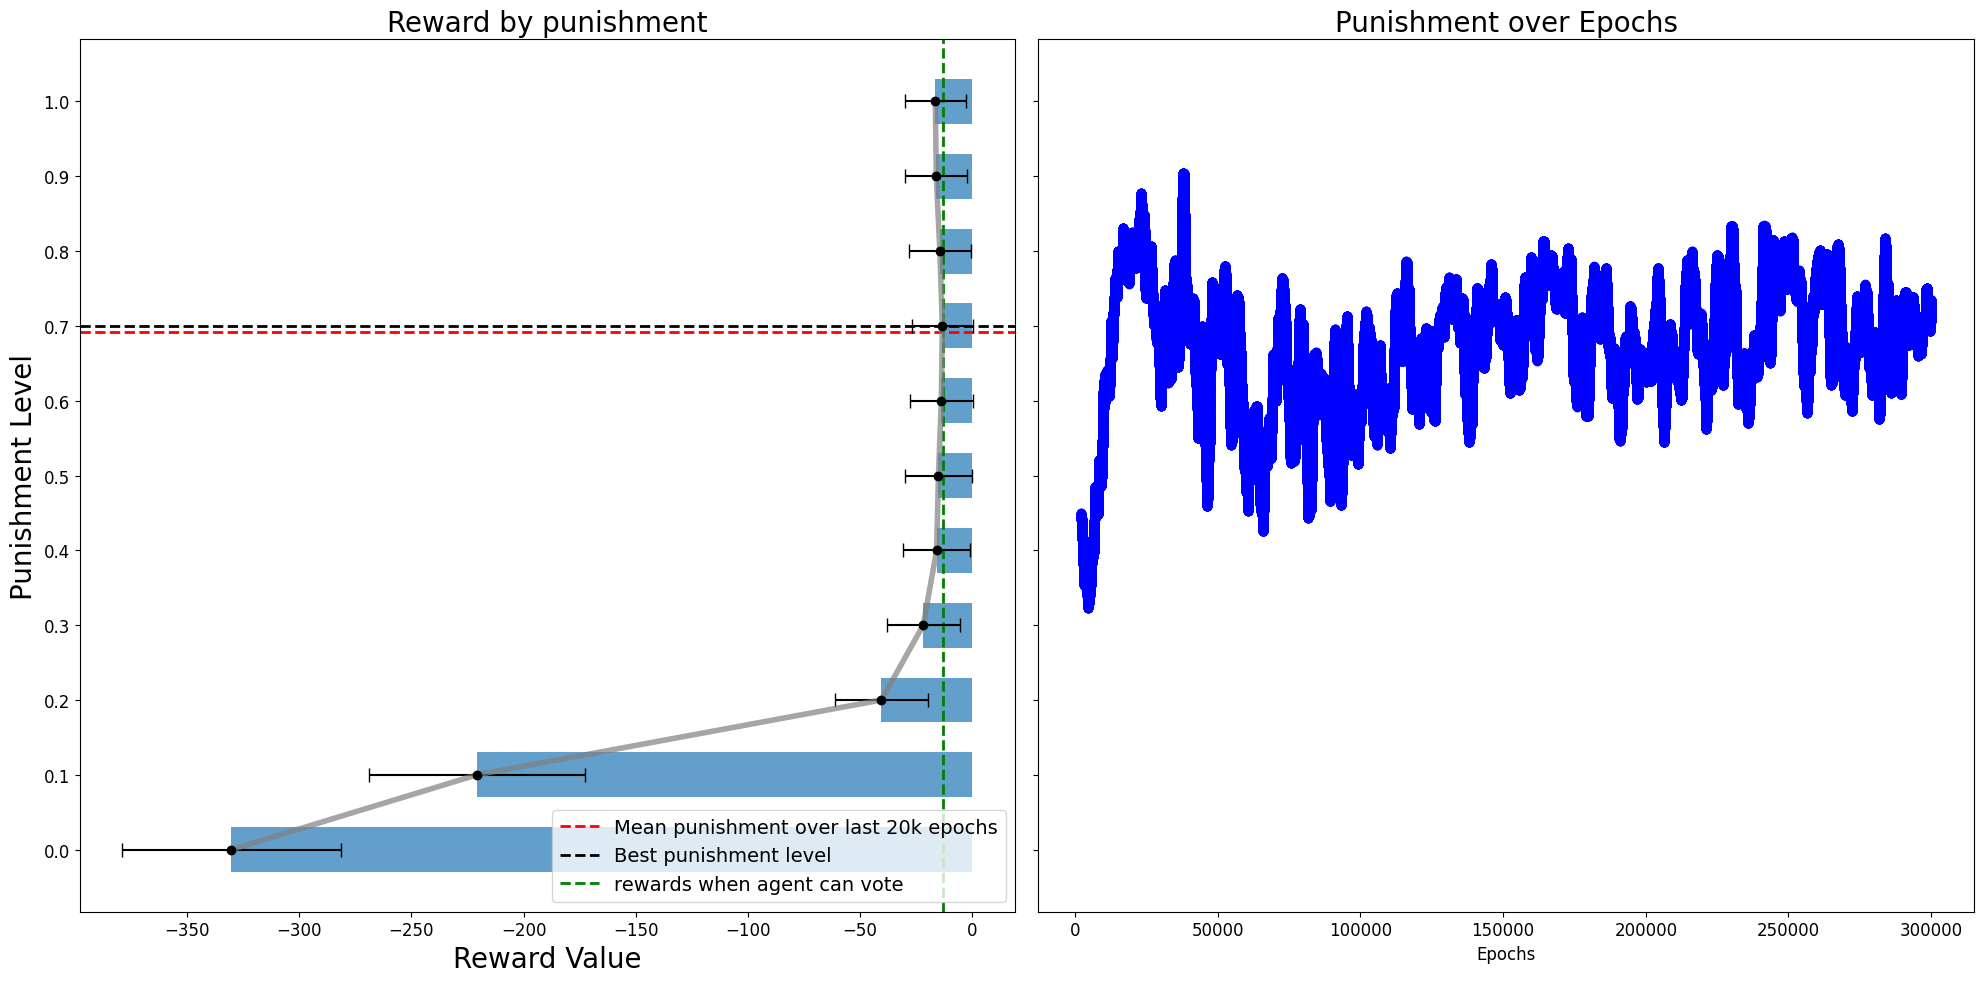

In [16]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

dir = 'res/runs/'
folders = os.listdir(dir)

voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251021-154042'
# voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134707'
# voting_run = "extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134620"
# Example data
punishment_levels = pd.read_csv(f'{dir}/{voting_run}/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=2000).mean()
epochs = list(range(len(punishment_levels)))
# get the reward for the voting condition
voting_reward = pd.read_csv(f'{dir}/{voting_run}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()

# get the reward for each fixed punishment level
rewards = []
# get the variance of the reward for each fixed punishment level
rewards_std = []
count = 0
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'p{i}' in f and 'prob' in f and 'n_tau_nstep5' in f and 'pnoobs'  and '6a' in f:
            reward = pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()
            rewards.append(reward)
            rewards_std.append(pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].std())
            has_f = True
            count += 1
            # print(count, i, f)
    if not has_f:
        rewards.append(0)
        rewards_std.append(0)


# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
# Left subplot: line plot (Epochs vs Punishment)
ax2.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
# use 1e+x for the ticks
#ax2.set_xticks([1e5*i for i in range(9)], [f"1e5*{i}" for i in range(9)])
ax2.set_yticks(ticks)
ax2.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax2.set_xlabel("Epochs")
ax2.set_title("Punishment over Epochs", fontsize=20)

ax1.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax1.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
ax1.axvline(voting_reward, color='green', linestyle='--', linewidth=2, label='rewards when agent can vote')
# Right subplot: bar plot (Reward vs Punishment)
ax1.barh(ticks, rewards, alpha=0.7, height=0.06)
# add error bars (should be horizontal) (+- rewards_std)
ax1.errorbar(rewards, ticks, xerr=rewards_std, fmt='o', color='black', capsize=5)
ax1.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax1.set_xlabel("Reward Value", fontsize=20)
ax1.set_title("Reward by punishment", fontsize=20)
# ax1.set_xlim(-20, 2)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel("Punishment Level", fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

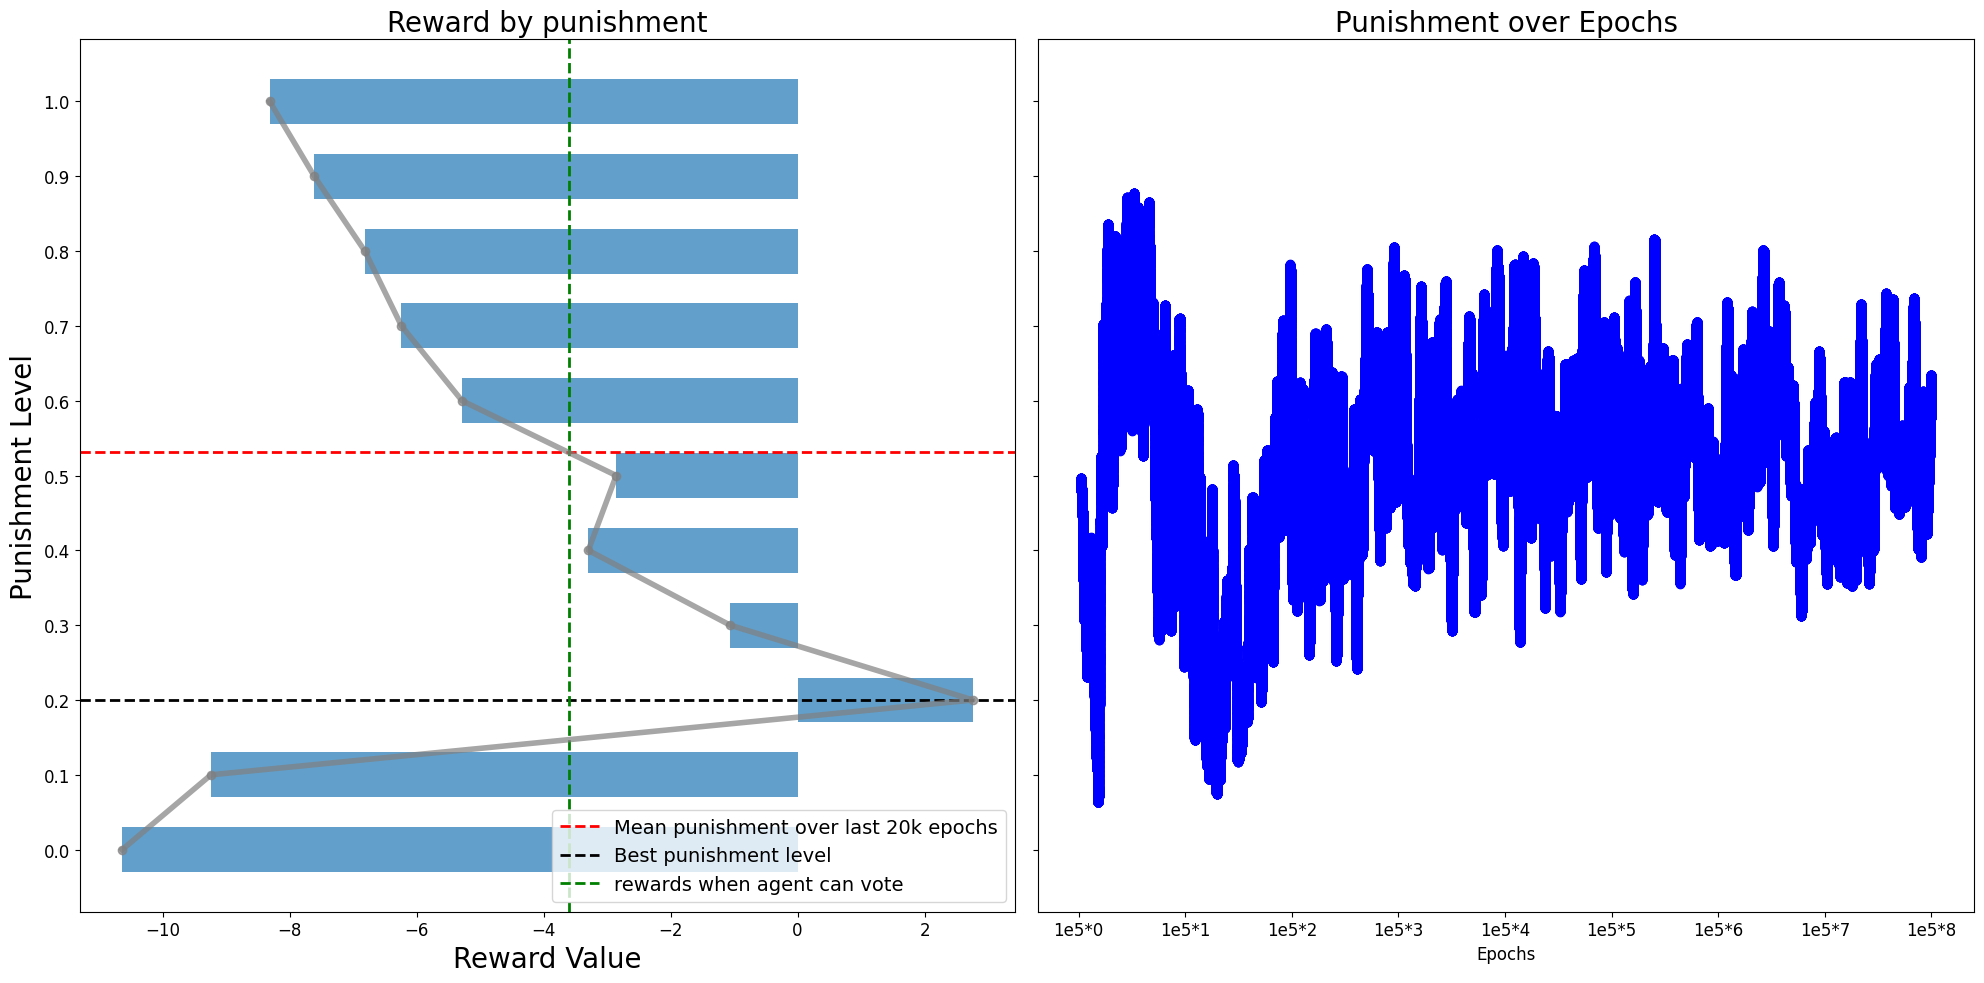

In [102]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

dir = 'res/runs_p48_a2_bs256_m2048/'
folders = os.listdir(dir)

voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_prob_ext_charm_immed_silly_pnoobs_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251008-230708'

# Example data
punishment_levels = pd.read_csv(f'{dir}/{voting_run}/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=2000).mean()
epochs = list(range(len(punishment_levels)))
# get the reward for the voting condition
voting_reward = pd.read_csv(f'{dir}/{voting_run}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()

# get the reward for each fixed punishment level
rewards = []
# get the variance of the reward for each fixed punishment level
rewards_std = []
count = 0
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'p{i}' in f and 'prob' in f and 'n_tau_nstep5' in f and 'pnoobs' in f:
            reward = pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()
            rewards.append(reward)
            rewards_std.append(pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].std())
            has_f = True
            count += 1
            # print(count, i, f)
    if not has_f:
        rewards.append(0)
        rewards_std.append(0)


# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
# Left subplot: line plot (Epochs vs Punishment)
ax2.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
# use 1e+x for the ticks
ax2.set_xticks([1e5*i for i in range(9)], [f"1e5*{i}" for i in range(9)])
ax2.set_yticks(ticks)
ax2.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax2.set_xlabel("Epochs")
ax2.set_title("Punishment over Epochs", fontsize=20)

ax1.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax1.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
ax1.axvline(voting_reward, color='green', linestyle='--', linewidth=2, label='rewards when agent can vote')
# Right subplot: bar plot (Reward vs Punishment)
ax1.barh(ticks, rewards, alpha=0.7, height=0.06)
# add error bars (should be horizontal) (+- rewards_std)
# ax1.errorbar(rewards, ticks, xerr=rewards_std, fmt='o', color='black', capsize=5)
ax1.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax1.set_xlabel("Reward Value", fontsize=20)
ax1.set_title("Reward by punishment", fontsize=20)
# ax1.set_xlim(-10, 10)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel("Punishment Level", fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

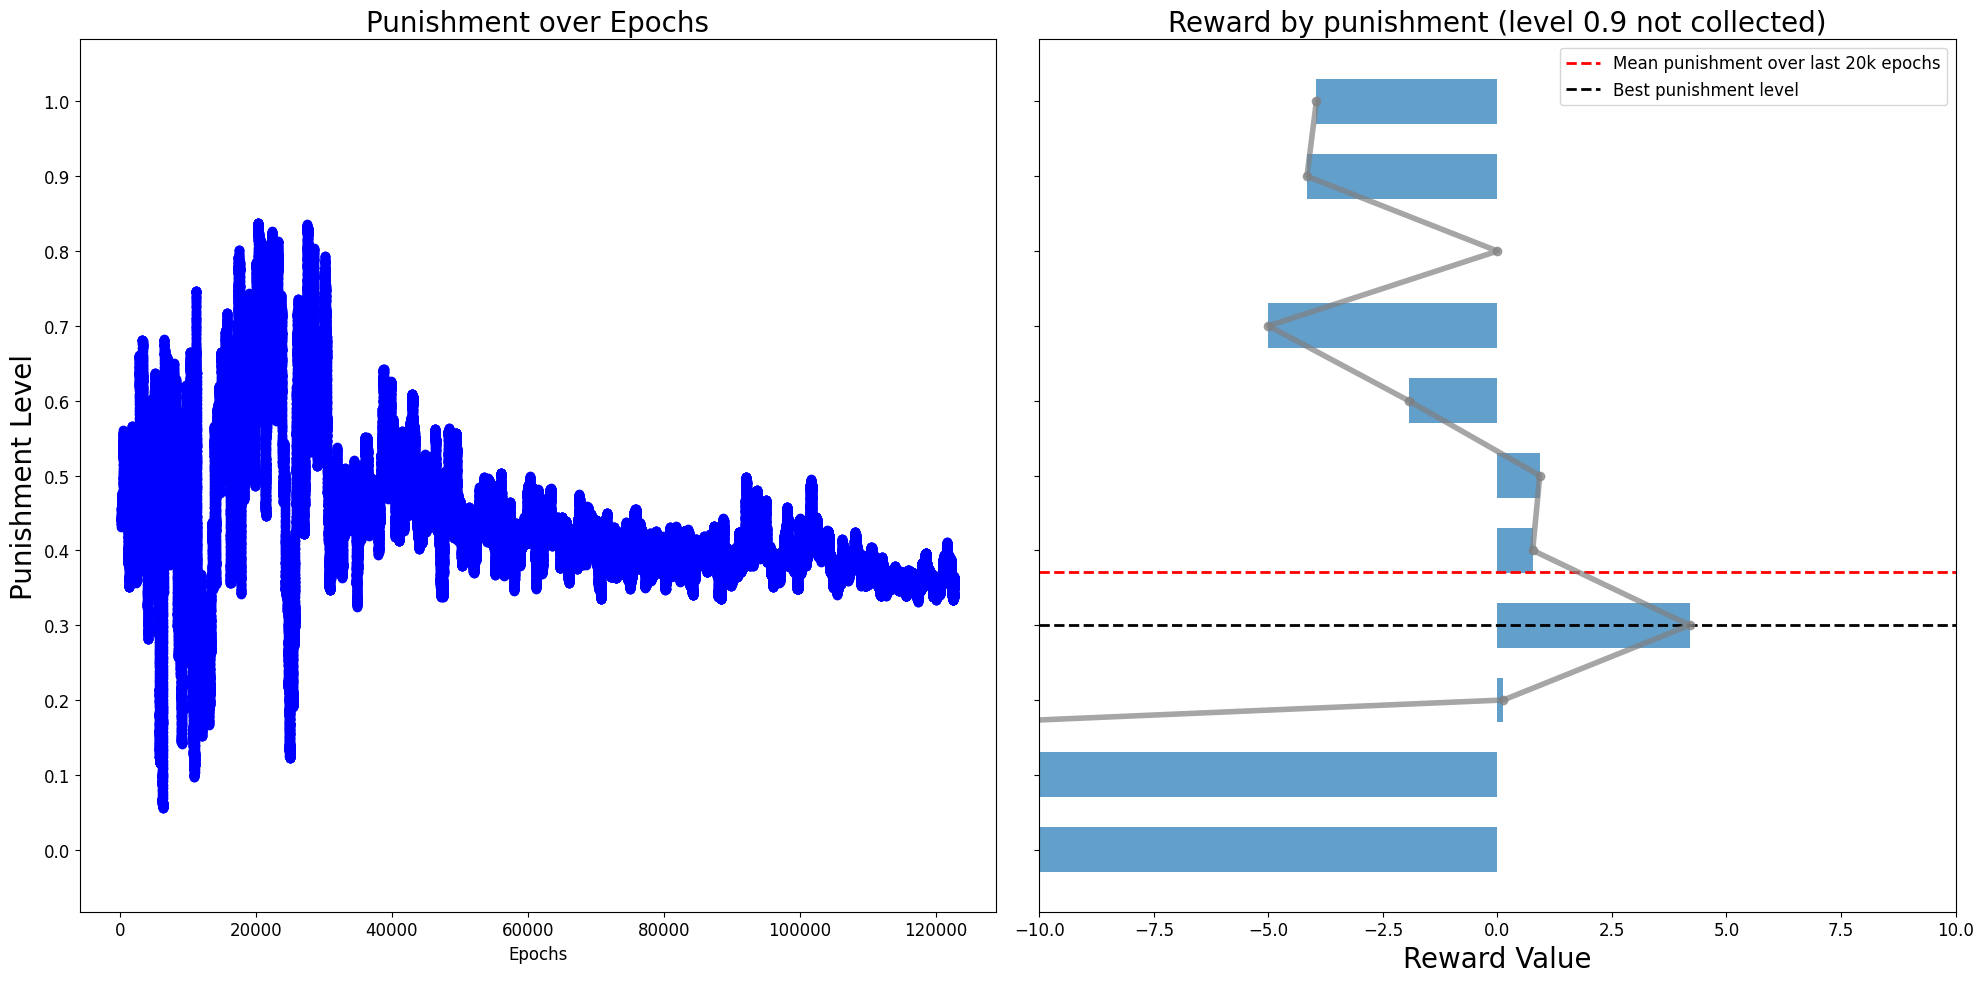

In [37]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

folders = os.listdir('res')

# Example data
punishment_levels = pd.read_csv('res/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__3agents_20250924-001840/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=200).mean()
epochs = list(range(len(punishment_levels)))
rewards = []
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'punish{i}' in f:
            reward = pd.read_csv(f'res/{f}/Mean_mean_individual_score_data.csv')['Value'][-1000:].mean()
            rewards.append(reward)
            has_f = True
    if not has_f:
        rewards.append(0)
    
    

# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

# Left subplot: line plot (Epochs vs Punishment)
ax1.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(ticks)
ax1.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Punishment Level", fontsize=20)
ax1.set_title("Punishment over Epochs", fontsize=20)

ax2.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax2.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
# Right subplot: bar plot (Reward vs Punishment)
ax2.barh(ticks, rewards, alpha=0.7, height=0.06)
ax2.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax2.set_xlabel("Reward Value", fontsize=20)
ax2.set_title("Reward by punishment (level 0.9 not collected)", fontsize=20)
ax2.set_xlim(-10, 10)
ax2.legend()
# Adjust layout
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Punishment over Epochs')

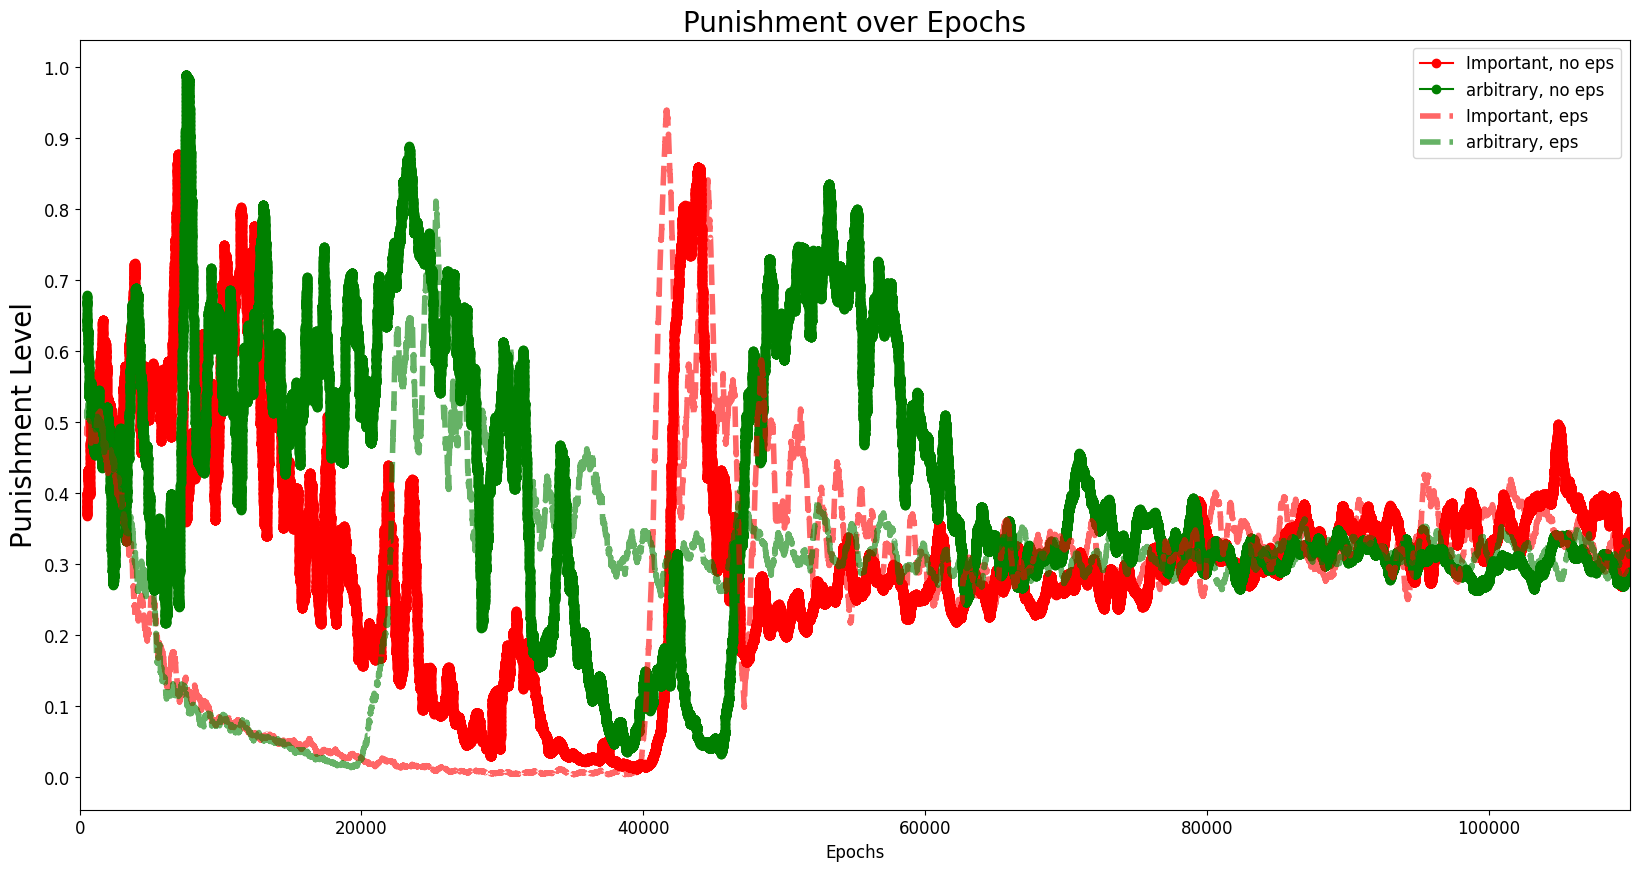

In [136]:
import matplotlib.pyplot as plt

folders = os.listdir('res')
wsize = 500
# Example data
#punishment_levels_important = pd.read_csv('res/runs_p48_a2_bs256_m2048/extended_random_exploration_v2_det_ext_charm_immed_important_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251004-165035/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_important = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134707/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important = pd.read_csv('res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251102-193735/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important = punishment_levels_important.rolling(window=wsize).mean()
epochs_important = list(range(len(punishment_levels_important)))


punishment_levels_important_with_eps = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235341/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important_with_eps = punishment_levels_important_with_eps.rolling(window=wsize).mean()
epochs_important_with_eps = list(range(len(punishment_levels_important_with_eps)))

#punishment_levels_silly = pd.read_csv('res/runs_p48run_a2_bs256_m2048/extended_random_exploration_v2_det_ext_charm_immed_silly_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251004-165111/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134620/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235425/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = pd.read_csv('res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251101-222151/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235341/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = punishment_levels_silly.rolling(window=wsize).mean()
epochs_silly = list(range(len(punishment_levels_silly)))    
    
punishment_levels_silly_with_eps = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235425/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly_with_eps = punishment_levels_silly_with_eps.rolling(window=wsize).mean()
epochs_silly_with_eps = list(range(len(punishment_levels_silly_with_eps)))

# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(20, 10))

# Left subplot: line plot (Epochs vs Punishment)
# ax1.plot(epochs, punishment_levels, marker='o', color="blue")
ax1.plot(epochs_important, punishment_levels_important, marker='o', color="red", label='Important, no eps')
ax1.plot(epochs_silly, punishment_levels_silly, marker='o', color="green", label='arbitrary, no eps')
ax1.plot(epochs_important_with_eps, punishment_levels_important_with_eps, color="red", label='Important, eps', linestyle='--', linewidth=4, alpha=0.6)
ax1.plot(epochs_silly_with_eps, punishment_levels_silly_with_eps,color="green", label='arbitrary, eps', linestyle='--', linewidth=4, alpha=0.6)
ax1.legend()
ax1.set_xlim(0, 110000)
ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(ticks)
ax1.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Punishment Level", fontsize=20)
ax1.set_title("Punishment over Epochs", fontsize=20)
# ax1.set_xlim(0, 60000)

## Simulated Results

In [47]:
def make_scatter_with_fitted_trendline(
    n_points=100,
    x_min=0.0,
    x_max=10.0,
    true_slope=-1.0,
    true_intercept=0.0,
    noise_std=1.0,        # std dev of normal errors
    seed=42,
    x_label="x",
    y_label="y",
    title="Scatter Plot with Fitted Trendline",
    show=True,
    save_path=None,
):
    """
    Generate a scatter plot of data from:
        y = true_slope * x + true_intercept + epsilon
    with epsilon ~ N(0, noise_std^2),
    and draw the fitted trendline from a least-squares fit.

    Parameters
    ----------
    n_points : int
        Number of data points.
    x_min, x_max : float
        Range for x values.
    true_slope : float
        Slope used to generate the data.
    true_intercept : float
        Intercept used to generate the data.
    noise_std : float
        Standard deviation of the normal errors.
    seed : int or None
        Random seed for reproducibility.
    x_label, y_label : str
        Axis labels.
    title : str
        Plot title.
    show : bool
        Whether to display the plot.
    save_path : str or None
        If provided, path to save the figure.

    Returns
    -------
    x : np.ndarray
    y : np.ndarray
    fitted_coeffs : np.ndarray  # [slope, intercept]
    """
    # ----- Data generation -----
    if seed is not None:
        np.random.seed(seed)

    x = np.linspace(x_min, x_max, n_points)

    # Normal errors
    eps = np.random.normal(loc=0.0, scale=noise_std, size=n_points)
    y = true_slope * x + true_intercept + eps

    # ----- Fit a line to (x, y) -----
    fitted_coeffs = np.polyfit(x, y, deg=1)  # [slope, intercept]

    x_line = np.linspace(x_min, x_max, 200)
    y_line = np.polyval(fitted_coeffs, x_line)

    # ----- Plot -----
    plt.figure()
    plt.scatter(x, y, alpha=0.7, label="Data")

    plt.plot(
        x_line,
        y_line,
        linewidth=2,
        color='red',
        alpha=0.6,
        label=f"Fitted: y = {fitted_coeffs[0]:.2f}x + {fitted_coeffs[1]:.2f}",
    )

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks([])
    plt.yticks([])

    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

    if show:
        plt.show()

    return x, y, fitted_coeffs


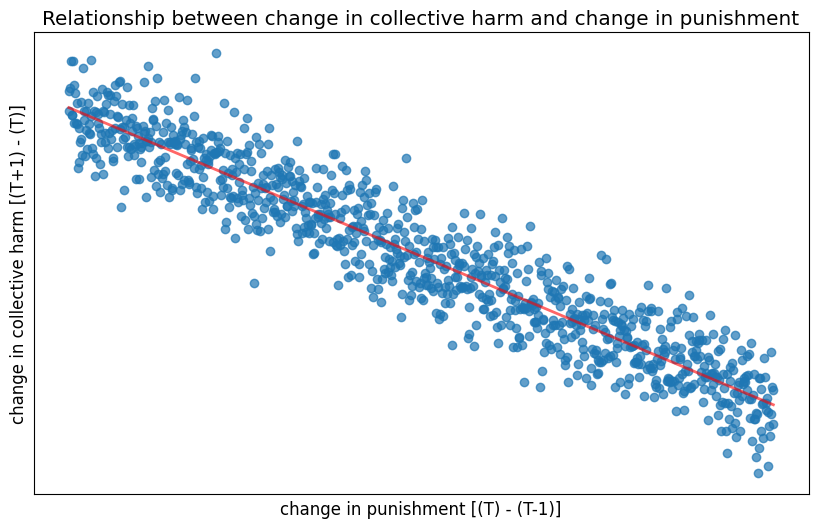

In [95]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=-1,  
y_label='change in collective harm [(T+1) - (T)]',
x_label='change in punishment [(T) - (T-1)]', 
title='Relationship between change in collective harm and change in punishment'
);

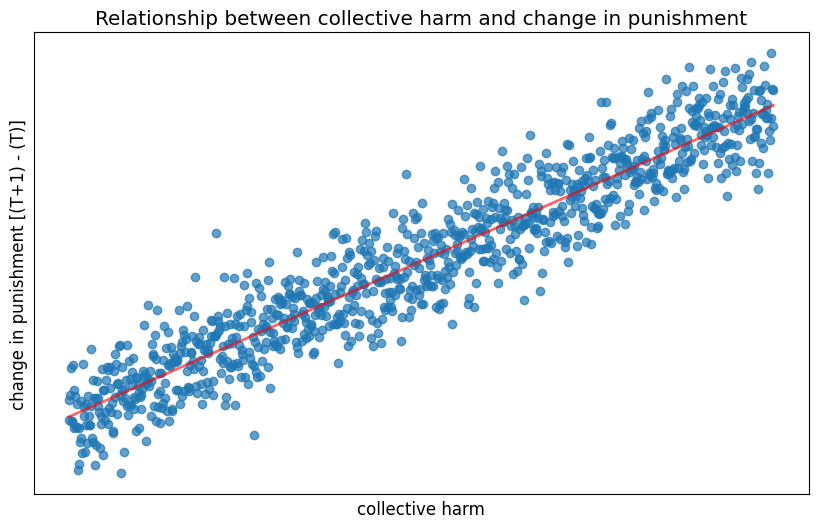

In [92]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=1,  
x_label='collective harm',
y_label='change in punishment [(T+1) - (T)]', 
title='Relationship between collective harm and change in punishment'
);

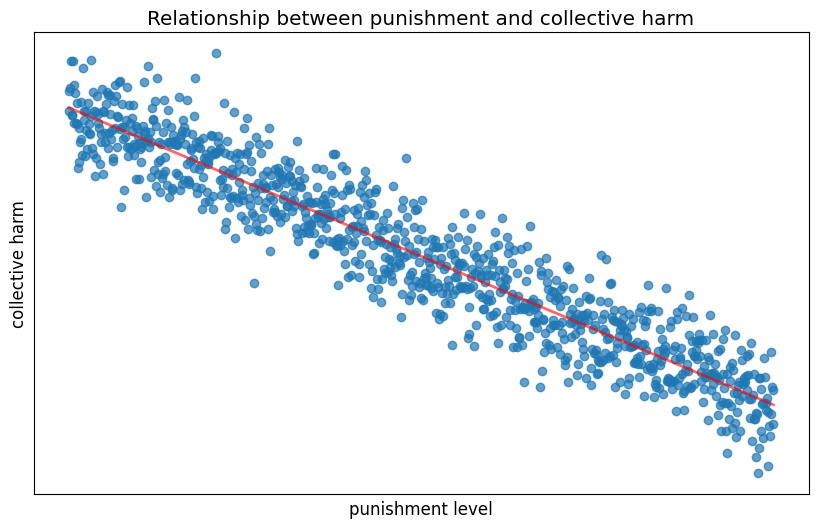

In [88]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=-1,  
x_label='punishment level',
y_label='collective harm', 
title='Relationship between punishment and collective harm'
);

## correlation plots


Social harm length: 471845
Punishment levels length: 471845
✓ Lengths match - both metrics logged once per epoch
Correlation between social harm and punishment: -0.5443, p-value: 0.0000


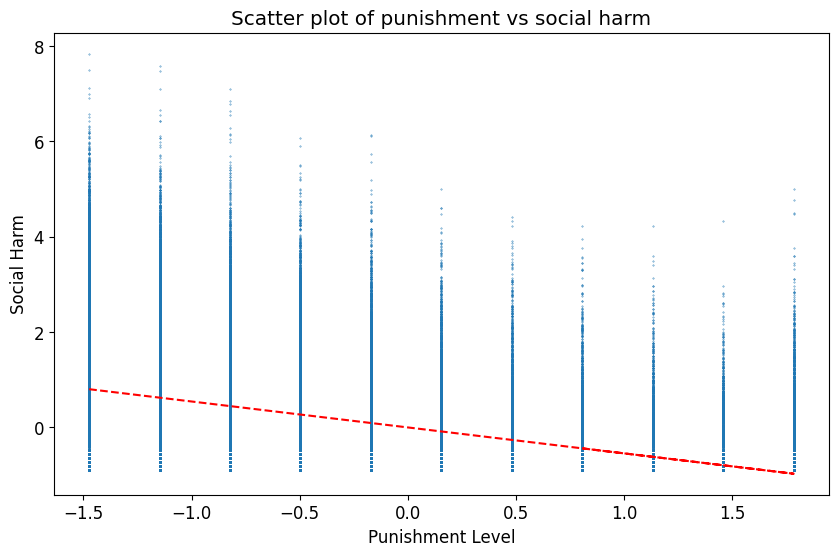

In [6]:
## correlation bewteen social harm and punishment (correlation test + scatter plot)

import numpy as np
import pandas as pd

f = [
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030',
    'res/runs_Nov14/epsilon0.0_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200443',
][0]

# parameters
wsize = 1
# Load social harm and punishment data
social_harm = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')['Value'].rolling(window=wsize).mean()[wsize:]
punishment_levels = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')['Value'].rolling(window=wsize).mean()[wsize:]

# Check if lengths match (they should - both are logged once per epoch)
# However, unequal lengths can occur due to:
# 1. TensorBoard event file corruption/incomplete writes
# 2. Early experiment termination (crash/interrupt)
# 3. Tag name changes between code versions
# 4. Partial logging failures
print(f"Social harm length: {len(social_harm)}")
print(f"Punishment levels length: {len(punishment_levels)}")
if len(social_harm) != len(punishment_levels):
    print(f"⚠️  WARNING: Length mismatch detected!")
    print(f"   Difference: {abs(len(social_harm) - len(punishment_levels))} epochs")
    print(f"   Possible causes: event file corruption, early termination, or logging issues")
    min_len = min(len(social_harm), len(punishment_levels))
    social_harm = social_harm[:min_len]
    punishment_levels = punishment_levels[:min_len]
    print(f"   Truncated both to length: {min_len} (using first {min_len} epochs)")
else:
    print("✓ Lengths match - both metrics logged once per epoch")

#parameters
lag = 1
start_timepoint = 200000

social_harm_transformed = zscore(social_harm[start_timepoint:])
punishment_levels_transformed = zscore(punishment_levels[start_timepoint:])
# Calculate correlation, p-value
correlation, p_value = pearsonr(social_harm_transformed, punishment_levels_transformed)
print(f"Correlation between social harm and punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(punishment_levels_transformed, social_harm_transformed, s=0.1)
plt.xlabel("Punishment Level")
plt.ylabel("Social Harm")
plt.title("Scatter plot of punishment vs social harm")
# trendline fitted for the relation
z = np.polyfit(punishment_levels_transformed, social_harm_transformed, 1)
p = np.poly1d(z)
plt.plot(punishment_levels_transformed, p(punishment_levels_transformed), "r--")
plt.show()



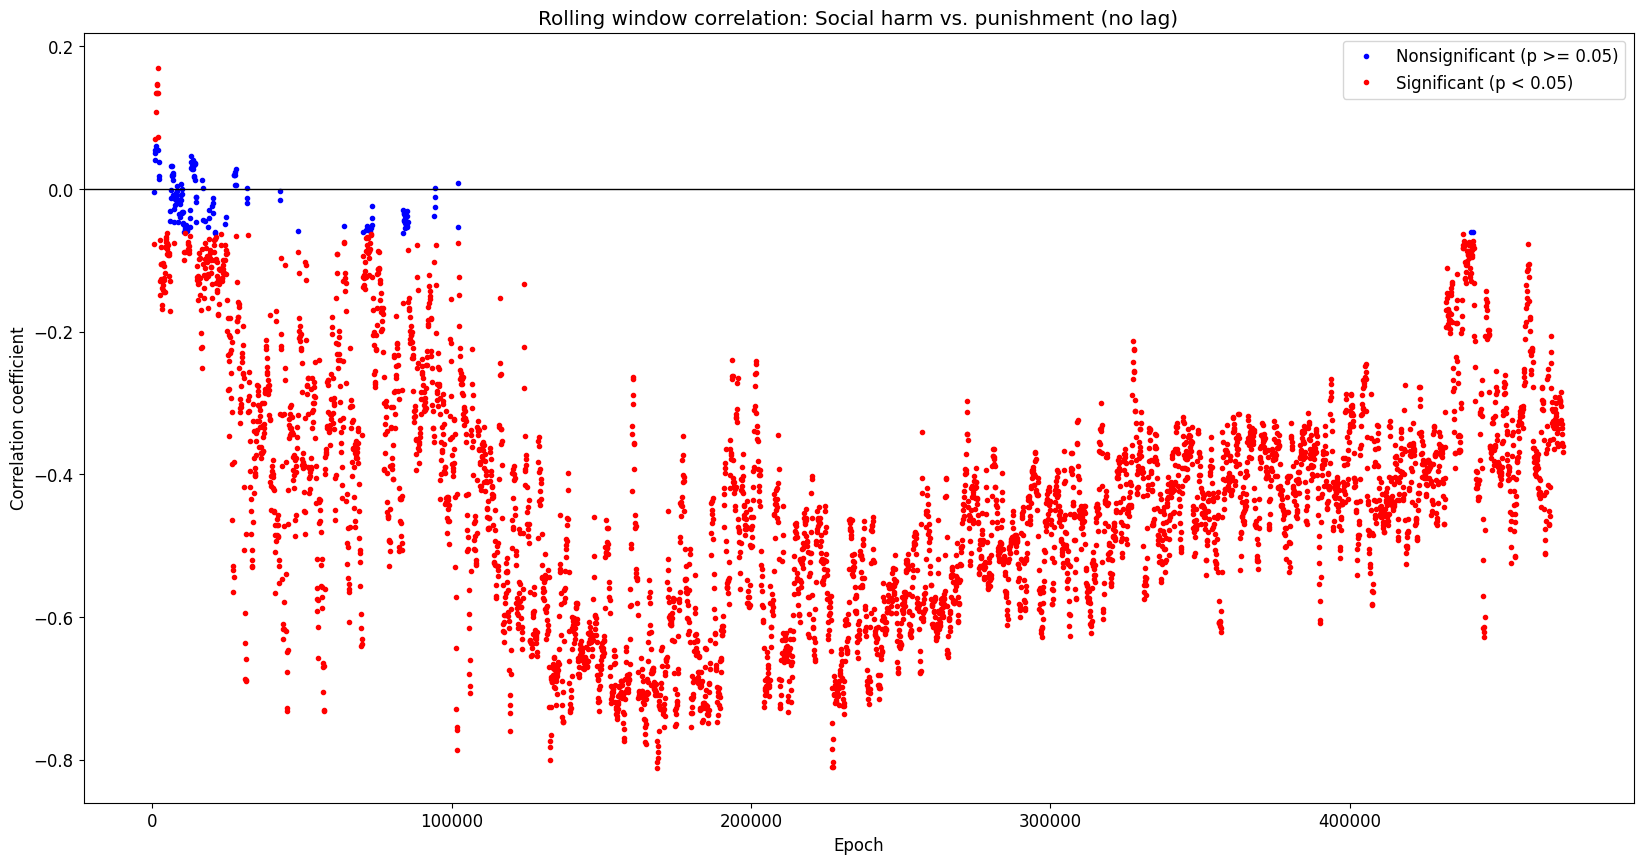

In [7]:
# rolling window: correlation between social harm and punishment (social harm at time T ~ p_T)
# rolling window: correlation between social harm and punishment (social harm at time T ~ p_T)
window_size = 1000
step_size = 100
lag = 1
start_timepoint = 0

correlations = []
p_values = []
window_centers = []

sh_win = social_harm[start_timepoint:]
p_win = punishment_levels[start_timepoint:]

for start in range(0, len(sh_win) - window_size + 1, step_size):
    end = start + window_size
    x_win = p_win[start:end]
    y_win = sh_win[start:end]
    # Only compute correlation if window has varied data
    if np.std(x_win) > 0 and np.std(y_win) > 0:
        corr, pval = pearsonr(x_win, y_win)
    else:
        corr, pval = np.nan, np.nan
    correlations.append(corr)
    p_values.append(pval)
    window_centers.append(start + window_size // 2)

correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

# Plotting, red for significant (p < 0.05), blue for nonsignificant
fig, ax = plt.subplots(figsize=(20, 10))

mask_sig = p_values < 0.05
mask_nonsig = ~mask_sig

ax.plot(window_centers[mask_nonsig], correlations[mask_nonsig], 'o', color='blue', label='Nonsignificant (p >= 0.05)', markersize=3)
ax.plot(window_centers[mask_sig], correlations[mask_sig], 'o', color='red', label='Significant (p < 0.05)', markersize=3)

ax.set_xlabel("Epoch")
ax.set_ylabel("Correlation coefficient")
ax.set_title("Rolling window correlation: Social harm vs. punishment (no lag)")
ax.legend()
ax.axhline(0, color='black', linewidth=1)
plt.show()




Correlation between first derivative of social harm and punishment: 0.1179, p-value: 0.0000


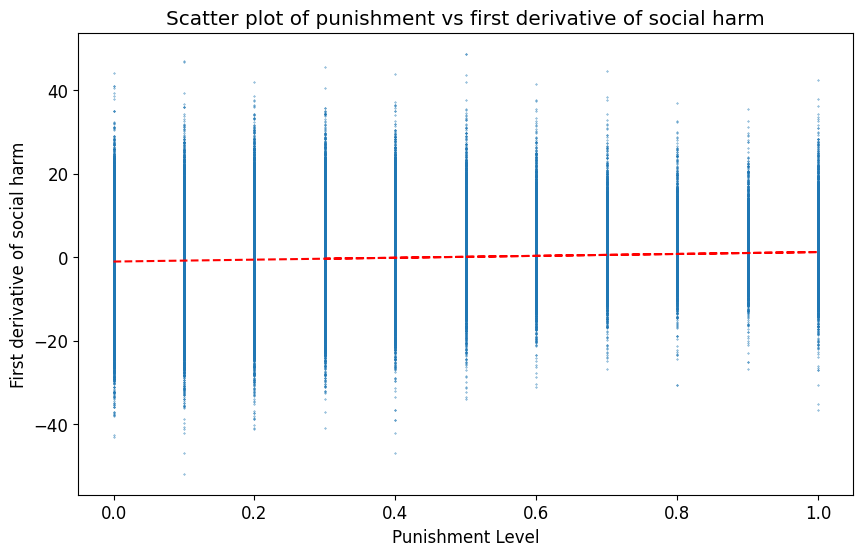

In [34]:
# correlation between first derivative of social harm and punishment (p at time T ~ delta harm_T)
lag = 1
start_timepoint = 200000
# Calculate first derivative of social harm
# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
# social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
social_harm_diff = social_harm[start_timepoint+1:].values - social_harm[start_timepoint:-1].values
social_harm_diff = social_harm_diff[lag-1:]

# Calculate correlation between first derivative of social harm and punishment
correlation, p_value = spearmanr(social_harm_diff, punishment_levels[start_timepoint:][:-lag])
print(f"Correlation between first derivative of social harm and punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(punishment_levels[start_timepoint:][:-lag], social_harm_diff, s=0.1)
plt.xlabel("Punishment Level")
plt.ylabel("First derivative of social harm")
plt.title("Scatter plot of punishment vs first derivative of social harm")
# trendline fitted for the relation
z = np.polyfit(punishment_levels[start_timepoint:][:-lag], social_harm_diff, 1)
p = np.poly1d(z)
plt.plot(punishment_levels[start_timepoint:][:-lag], p(punishment_levels[start_timepoint:][:-lag]), "r--")


In [8]:
import statsmodels.api as sm
import numpy as np

# define Δx_{t+1}
dx = social_harm[1:].values - social_harm[:-1].values

# align x_t and s_t to match Δx_{t+1}
x_t = social_harm[:-1].values
s_t = punishment_levels[:-1].values

# regression: Δx ~ x + s
X = np.column_stack([x_t, s_t])
X = sm.add_constant(X)

model = sm.OLS(dx, X).fit()
print(model.summary())

X = np.column_stack([s_t])
X = sm.add_constant(X)
model_ = sm.OLS(dx, X).fit()
print(model_.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                 6.223e+04
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:52:23   Log-Likelihood:            -1.4612e+06
No. Observations:              471844   AIC:                         2.922e+06
Df Residuals:                  471841   BIC:                         2.922e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8252      0.020    236.755      0.0

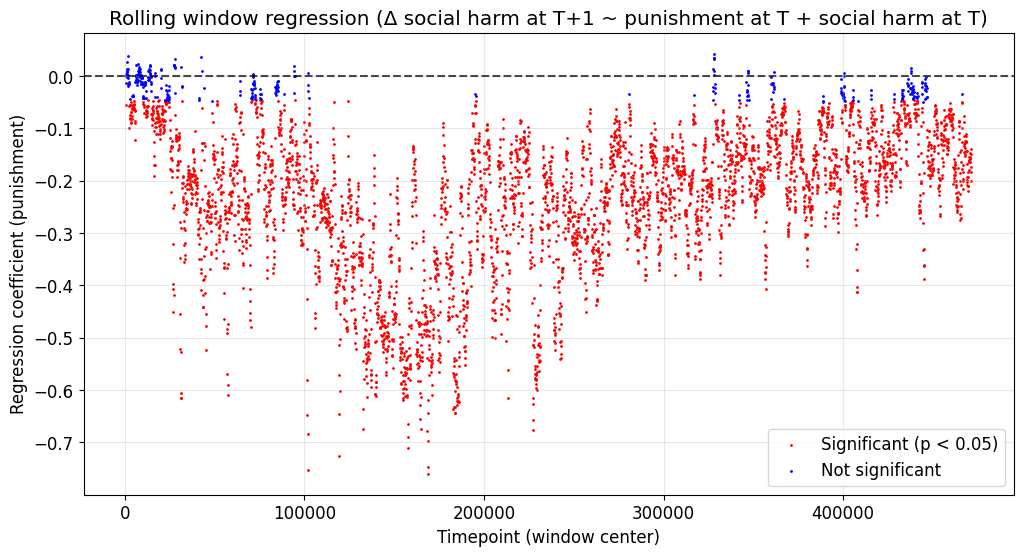

In [9]:
# rolling window: regression Δx_{t+1} ~ x_t + s
window_size = 1000
step_size = 100
lag = 1
start_timepoint = 0

correlations = []
p_values = []
window_centers = []

# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
punishment_for_corr = punishment_levels[start_timepoint:][:-lag]
social_harm_for_corr = social_harm[start_timepoint:][:-lag]

# instead of correlation, we do regression test, where we regress Δx_{t+1} ~ x_t + s, where x_t is social harm at time T, and s is the change in punishment at time T+lag - T
import statsmodels.api as sm

s_coefs = []
s_pvalues = []
window_centers = []

for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
    end = start + window_size
    x_win = social_harm_for_corr[start:end].values
    s_win = punishment_for_corr[start:end].values
    y_win = social_harm_diff[start:end]

    # z-score all variables
    x_win_z = zscore(x_win)
    s_win_z = zscore(s_win)
    y_win_z = zscore(y_win)

    # Prepare regression matrix: Δx_{t+1} ~ x_t + s
    X = np.column_stack([x_win_z, s_win_z])
    X = sm.add_constant(X)
    model = sm.OLS(y_win_z, X).fit()
    # Store coefficient and p-value of s (punishment)
    s_coefs.append(model.params[2])      # index 2 is the coefficient for s
    s_pvalues.append(model.pvalues[2])   # index 2 is p-value for s
    window_centers.append(start + window_size // 2)

# Convert to arrays for plotting
s_coefs = np.array(s_coefs)
s_pvalues = np.array(s_pvalues)
window_centers = np.array(window_centers)

# Plot rolling coefficient for punishment (s) with significance
plt.figure(figsize=(12,6))
plt.axhline(0, color='k', linestyle='--', alpha=0.7)
# Significant: red; Not significant: blue
alpha = 0.05
is_significant = s_pvalues < alpha
plt.scatter(window_centers[is_significant], s_coefs[is_significant], color='red', label='Significant (p < 0.05)', s=1)
plt.scatter(window_centers[~is_significant], s_coefs[~is_significant], color='blue', label='Not significant', s=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Regression coefficient (punishment)")
plt.title(f"Rolling window regression (Δ social harm at T+{lag} ~ punishment at T + social harm at T)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




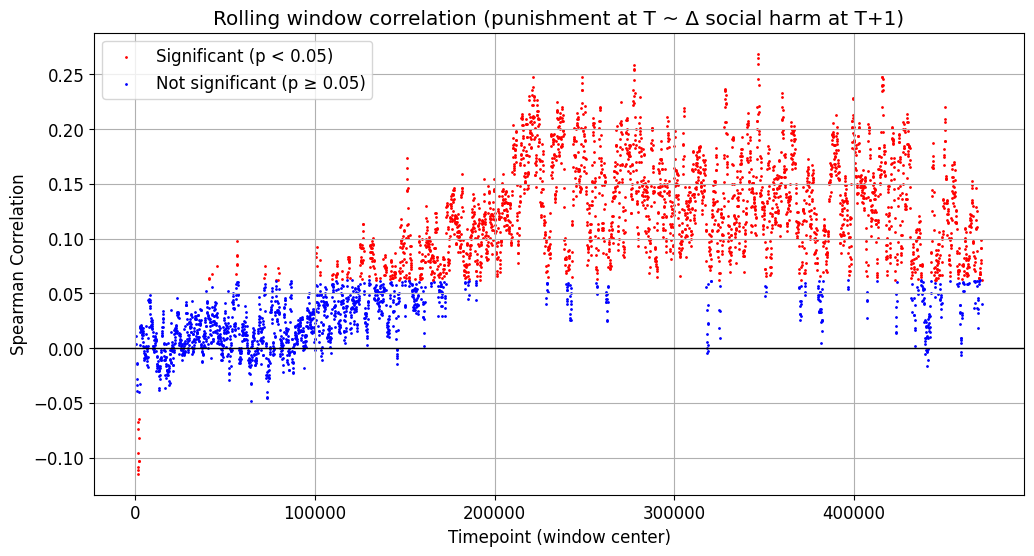

In [10]:
# rolling window: correlation between first derivative of social harm and punishment (p at time T ~ delta harm_T)
window_size = 1000
step_size = 100
lag = 1
start_timepoint = 0

correlations = []
p_values = []
window_centers = []

# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
punishment_for_corr = punishment_levels[start_timepoint:][:-lag]

for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
    end = start + window_size
    x_win = punishment_for_corr[start:end]
    y_win = social_harm_diff[start:end]
    # Only compute correlation if window has varied data
    if np.std(x_win) > 0 and np.std(y_win) > 0:
        corr, pval = spearmanr(x_win, y_win)
    else:
        corr, pval = np.nan, np.nan
    correlations.append(corr)
    p_values.append(pval)
    window_centers.append(start + window_size // 2)

# plt.figure(figsize=(12,6))
# plt.plot(window_centers, correlations, marker="o")
# plt.xlabel("Timepoint (window center)")
# plt.ylabel("Spearman Correlation")
# plt.title("Rolling window correlation (punishment ~ Δ social harm)")
# plt.grid()
# plt.show()
# Redo plot as scatter, red for significant, blue for not significant
plt.figure(figsize=(12,6))
correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = p_values < alpha

# Plot significant (red) and not significant (blue) points
plt.scatter(window_centers[is_significant], correlations[is_significant], s=1, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], correlations[~is_significant], s=1, color='blue', label="Not significant (p ≥ 0.05)")

plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Spearman Correlation")
plt.title(f"Rolling window correlation (punishment at T ~ Δ social harm at T+{lag})")
plt.legend()
plt.grid()
plt.show()



Correlation between social harm and first derivative of punishment: 0.1722, p-value: 0.0000


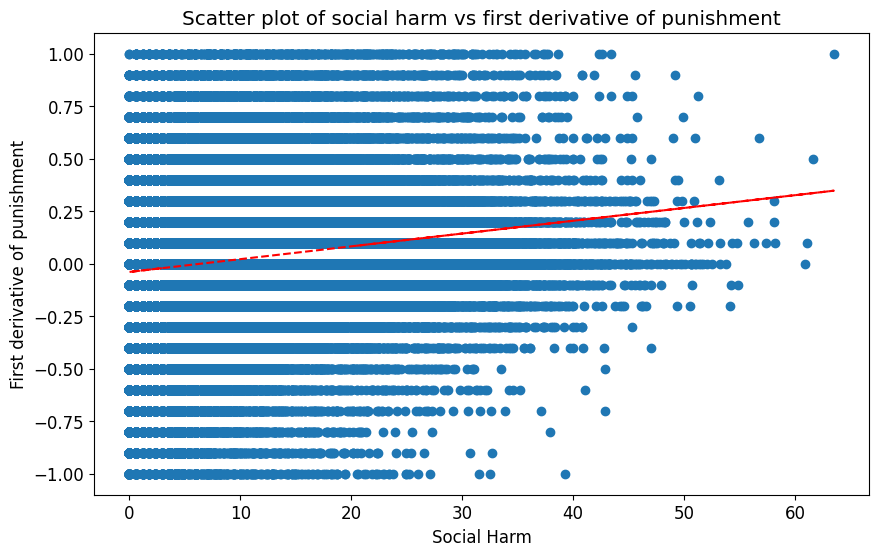

In [35]:
# correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)
lag = 1
start_timepoint = 200000
# Calculate first derivative of punishment
# punishment_diff = np.diff(punishment_levels[start_timepoint:], n=lag)
punishment_diff = punishment_levels[start_timepoint+lag:].values - punishment_levels[start_timepoint:-lag].values

# Calculate correlation between social harm and first derivative of punishment
correlation, p_value = spearmanr(social_harm[start_timepoint:][:-lag], punishment_diff)
print(f"Correlation between social harm and first derivative of punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(social_harm[start_timepoint:][:-lag], punishment_diff)
plt.xlabel("Social Harm")
plt.ylabel("First derivative of punishment")
plt.title("Scatter plot of social harm vs first derivative of punishment")
# trendline fitted for the relation
z = np.polyfit(social_harm[start_timepoint:][:-lag], punishment_diff, 1)
p = np.poly1d(z)
plt.plot(social_harm[start_timepoint:][:-lag], p(social_harm[start_timepoint:][:-lag]), "r--")

In [22]:
len(correlations)

4709

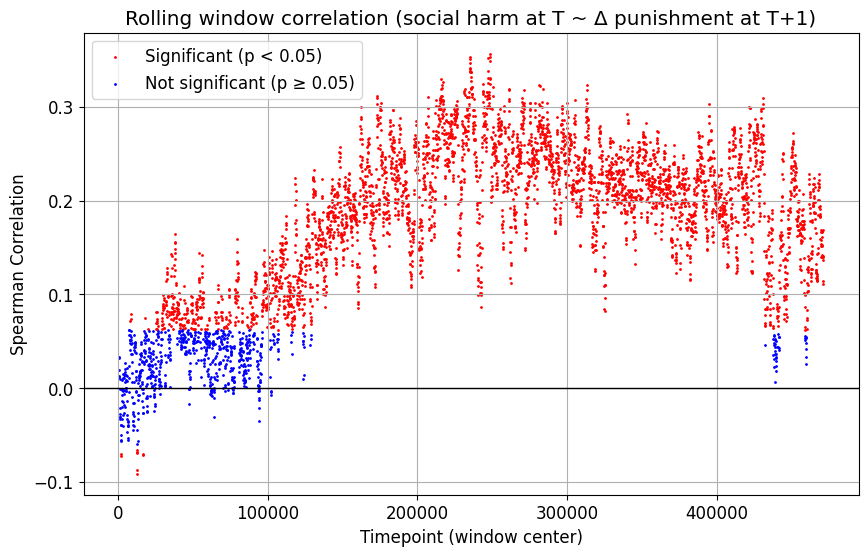

In [21]:
# rolling window: correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)

# rolling window: correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)
import numpy as np
from scipy.stats import spearmanr

window_size = 1000
step_size = 100
start_timepoint = 0
lag = 1

social_harm_arr = np.array(social_harm[start_timepoint:])
punishment_arr = np.array(punishment_levels[start_timepoint:])

social_harm_windows = []
correlations = []
p_values = []
window_centers = []

for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
    stop = start + window_size
    # x: social harm (T), y: change in punishment (T+lag - T)
    x = social_harm_arr[start:stop-lag]
    # y = np.diff(punishment_arr[start:(stop+lag)], n=lag)
    y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]

    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        corr = np.nan
        p = np.nan
    else:
        corr, p = spearmanr(x, y)
    correlations.append(corr)
    p_values.append(p)
    window_centers.append(start + window_size//2)

correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = p_values < alpha

plt.figure(figsize=(10,6))
plt.scatter(window_centers[is_significant], correlations[is_significant], s=1, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], correlations[~is_significant], s=1, color='blue', label="Not significant (p ≥ 0.05)")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Spearman Correlation")
plt.title(f"Rolling window correlation (social harm at T ~ Δ punishment at T+{lag})")
plt.legend()
plt.grid()
plt.show()






271844
271844
271843
Correlation between first derivative of social harm and first derivative of punishment: 0.0446, p-value: 0.0000


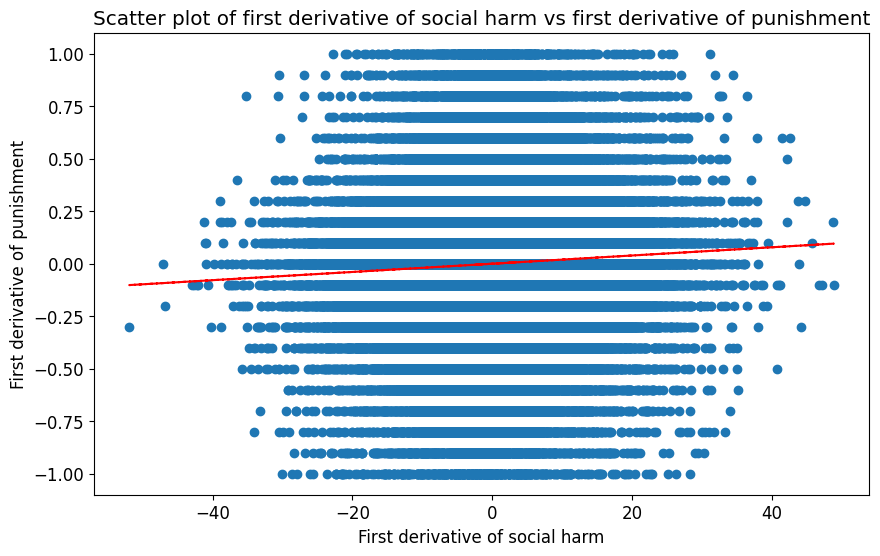

In [48]:
# correlation between first derivative of social harm at T + 1 and the first derivative of punishment at T
lag = 1
start_timepoint = 200000


# social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
# social_harm_diff = social_harm_diff[lag:]
# punishment_diff = punishment_levels[start_timepoint+lag:].values - punishment_levels[start_timepoint:-lag].values
# punishment_diff = punishment_diff[:-lag]
social_harm_diff = social_harm[start_timepoint+1:].values - social_harm[start_timepoint:-1].values
print(len(social_harm_diff))
social_harm_diff = social_harm_diff[lag:]
punishment_diff = punishment_levels[start_timepoint+1:].values - punishment_levels[start_timepoint:-1].values
print(len(punishment_diff))
len_ = len(punishment_diff)
punishment_diff = punishment_diff[:len_-lag]
print(len(punishment_diff))
correlation, p_value = pearsonr(social_harm_diff, punishment_diff)
print(f"Correlation between first derivative of social harm and first derivative of punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(social_harm_diff, punishment_diff)
plt.xlabel("First derivative of social harm")
plt.ylabel("First derivative of punishment")
plt.title("Scatter plot of first derivative of social harm vs first derivative of punishment")
# trendline fitted for the relation
z = np.polyfit(social_harm_diff, punishment_diff, 1)
p = np.poly1d(z)
plt.plot(social_harm_diff, p(social_harm_diff), "r--")




In [51]:
# define Δx_{t+1}
start_timepoint = 250000
social_harm_ = social_harm[start_timepoint:]
punishment_ = punishment_levels[start_timepoint:]
dx = social_harm_[1:].values - social_harm_[:-1].values
dx = dx[1:]

# align x_t and s_t to match Δx_{t+1}
x_t = social_harm_[1:-1].values
s_t = punishment_[:-1].values
ds = s_t[1:] - s_t[:-1]


# regression: Δx+1 ~ x+1 + Δs
X = np.column_stack([x_t, ds])
X = sm.add_constant(X)

model = sm.OLS(dx, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                 4.173e+04
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:32:27   Log-Likelihood:            -6.6601e+05
No. Observations:              221843   AIC:                         1.332e+06
Df Residuals:                  221840   BIC:                         1.332e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6781      0.014    192.463      0.0

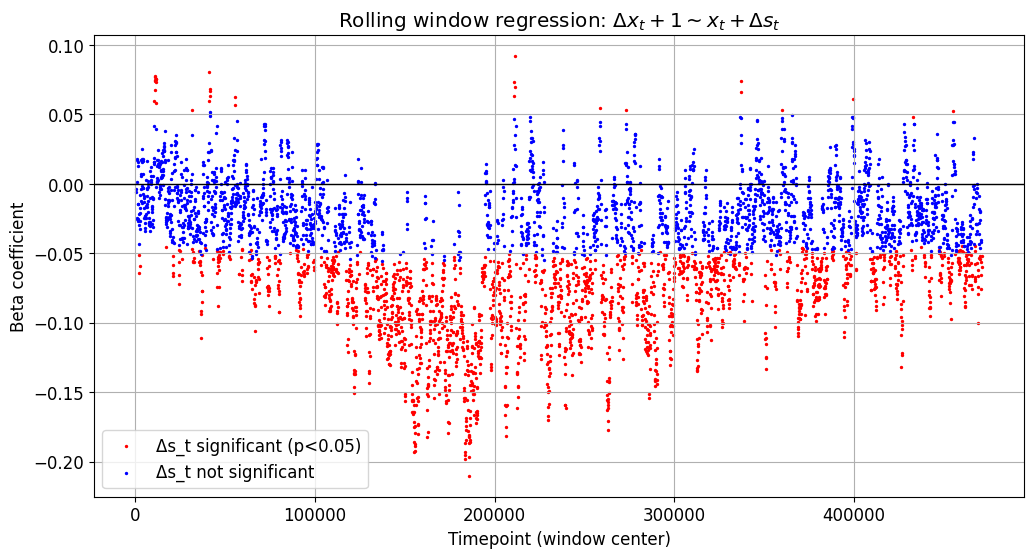

In [39]:
# rolling window: regression Δx_{t+1} ~ x_t + Δs_t

import statsmodels.api as sm

from scipy.stats import zscore

window_size = 1000
step_size = 100
start_timepoint = 0
# Prepare the series
social_harm_arr = np.array(social_harm[start_timepoint:])
punishment_arr = np.array(punishment_levels[start_timepoint:])

dx = social_harm_arr[1:] - social_harm_arr[:-1]
dx = dx[1:]
xvals = social_harm_arr[1:-1]
svals = punishment_arr[:-1]
ds = svals[1:] - svals[:-1]


dx = dx[:]
x_t = xvals[:]
ds_t = ds[:]

n_points = len(x_t)
rolling_coefs = []
rolling_pvalues = []
window_centers = []

for start in range(0, n_points - window_size + 1, step_size):
    end = start + window_size

    # Prepare variables for regression in the window
    y_win = dx[start:end]
    x_win = x_t[start:end]
    ds_win = ds_t[start:end]
    
    # z-score all variables
    y_win_z = zscore(y_win)
    x_win_z = zscore(x_win)
    ds_win_z = zscore(ds_win)

    # Design matrix: x_t, Δs_t (with constant intercept)
    X = np.column_stack([x_win_z, ds_win_z])
    X = sm.add_constant(X)
    model = sm.OLS(y_win_z, X).fit()
    
    rolling_coefs.append(model.params[2])        # coefficients [x_t, Δs_t]
    rolling_pvalues.append(model.pvalues[2])     # p-values [x_t, Δs_t]
    window_centers.append(start + window_size // 2)

rolling_coefs = np.array(rolling_coefs)     # shape: [windows, 2]
rolling_pvalues = np.array(rolling_pvalues) # shape: [windows, 2]
window_centers = np.array(window_centers)

# Plot, marking statistically significant coefficients as in prior code
alpha = 0.05
is_significant_ds = rolling_pvalues < alpha

plt.figure(figsize=(12,6))
plt.scatter(window_centers[is_significant_ds], rolling_coefs[is_significant_ds], s=2, color='red', label="Δs_t significant (p<0.05)")
plt.scatter(window_centers[~is_significant_ds], rolling_coefs[~is_significant_ds], s=2, color='blue', label="Δs_t not significant")
plt.axhline(0, color='black', linewidth=1)

plt.xlabel("Timepoint (window center)")
plt.ylabel("Beta coefficient")
plt.title(r"Rolling window regression: $\Delta x_t+1 \sim x_t + \Delta s_t$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# instead of looking the collective level metrics, we look at the individual voting behaviors and the harm they received


In [22]:
# calculate the correlation between the encounters of entity e at time t and the change of punishment at time t+1

import numpy as np
import pandas as pd

# Load entity E encounter data and punishment level data
# Assume the encounter data is in a CSV with a 'Value' column, one value per epoch
entity_e_encounters = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Mean_mean_e_encounters_data.csv'
)['Value']

punishment_levels = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Global_average_punishment_level_data.csv'
)['Value']

# Calculate the change in punishment at t+1
punishment_diff = punishment_levels.values[1:] - punishment_levels.values[:-1]
punishment_diff = punishment_diff[:1000]

# Truncate to the same length
min_len = min(len(entity_e_encounters)-1, len(punishment_diff))
entity_e_encounters = entity_e_encounters[:min_len]
punishment_diff = punishment_diff[:min_len]

# Calculate correlation
correlation, p_value = pearsonr(entity_e_encounters, punishment_diff)
print(f"Correlation between mean entity E encounters at time t and change of punishment at time t+1: {correlation:.4f}, p-value: {p_value:.4f}")


Correlation between mean entity E encounters at time t and change of punishment at time t+1: -0.0335, p-value: 0.2903


Correlation between reward at time t and change of punishment at time t+1: 0.0453


/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_1207/1356432352.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x_win[mask], y_win[mask])


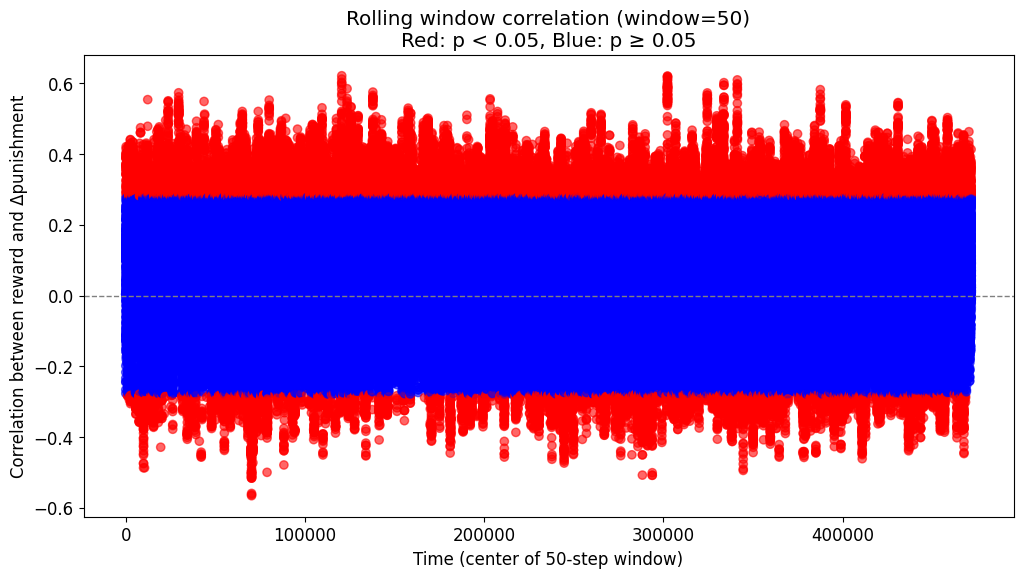

In [24]:
# calculate the correlation between the reward at time t and the change of punishment at time t+1
import numpy as np
import pandas as pd

# Load reward and punishment data
reward_series = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Mean_mean_individual_score_data.csv'
)['Value']

punishment_levels = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Global_average_punishment_level_data.csv'
)['Value']


# Align lengths after rolling
min_len = min(len(reward_series)-1, len(punishment_levels)-1)
reward_series = reward_series[:min_len]
punishment_levels = punishment_levels[:min_len]

# Calculate the change in punishment at t+1
punishment_diff = punishment_levels.values[1:] - punishment_levels.values[:-1]
reward_series_aligned = reward_series.values[:-1]  # reward at time t

# Truncate to same length
min_len2 = min(len(reward_series_aligned), len(punishment_diff))
reward_series_aligned = reward_series_aligned[:min_len2]
punishment_diff = punishment_diff[:min_len2]

# Calculate correlation
correlation = np.corrcoef(reward_series_aligned, punishment_diff)[0, 1]
print(f"Correlation between reward at time t and change of punishment at time t+1: {correlation:.4f}")

window_size = 50
# For plotting, align the x-axis to the center of each window
corrs, pvals, _ = rolling_window_correlation(reward_series_aligned, punishment_diff, window_size)

x = np.arange(len(corrs)) + window_size // 2

plt.figure(figsize=(12,6))
# Color by p-value: red if p < 0.05, blue otherwise
colors = np.where(pvals < 0.05, 'red', 'blue')
plt.scatter(x, corrs, c=colors, alpha=0.6, label='Rolling correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f"Time (center of {window_size}-step window)")
plt.ylabel("Correlation between reward and Δpunishment")
plt.title(f"Rolling window correlation (window={window_size})\nRed: p < 0.05, Blue: p ≥ 0.05")
plt.show()


Correlation between punishment at time t and change in reward at t+1: 0.0467


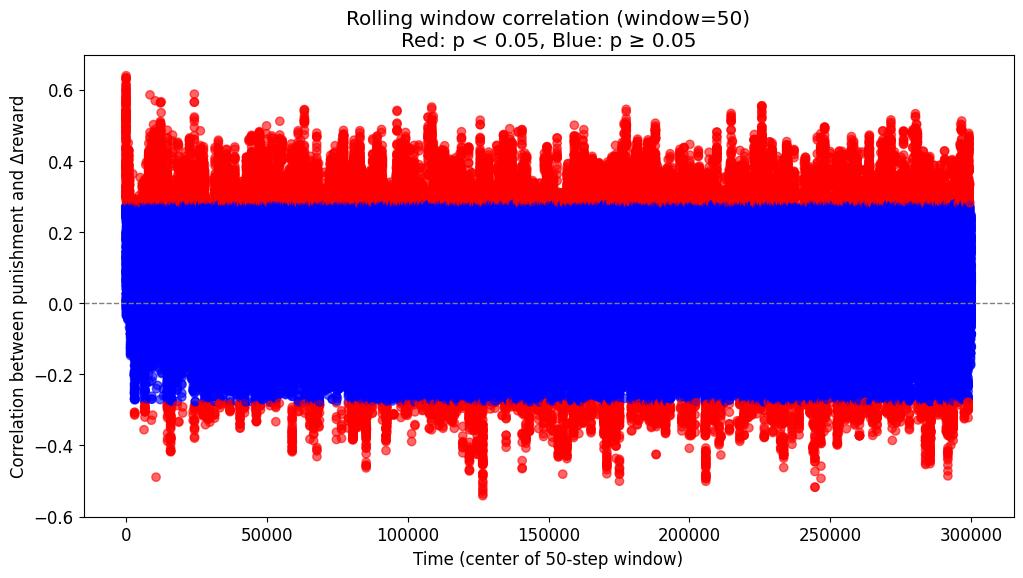

In [114]:
# calculate the correlation between the punishment at time t and the change of reward at time t+1

import numpy as np
import pandas as pd

# Load punishment levels and rewards
punishment_levels = pd.read_csv('res/runs_p48_a2_deterministic/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Global_average_punishment_level_data.csv')['Value']
# punishment_levels = punishment_levels.rolling(window=2000).mean()
# punishment_levels = punishment_levels.dropna()
# For reward, we need a time series matching the epochs of punishment_levels
# we will use the same reward time series as above
reward_series = pd.read_csv('res/runs_p48_a2_deterministic/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Mean_mean_individual_score_data.csv')['Value']
# reward_series = reward_series.rolling(window=2000).mean()
# reward_series = reward_series.dropna()


# Calculate the change in reward at t+1

reward_diff = reward_series.values[2:] - reward_series.values[:-2]

# Truncate to the same length
min_len = min(len(punishment_levels), len(reward_diff))
punishment_levels = punishment_levels[:min_len]
reward_diff = reward_diff[:min_len]

# Calculate correlation
correlation = np.corrcoef(punishment_levels, reward_diff)[0, 1]
print(f"Correlation between punishment at time t and change in reward at t+1: {correlation:.4f}")


window_size = 50
# For plotting, align the x-axis to the center of each window
corrs, pvals, prop = rolling_window_correlation(punishment_levels, reward_diff, window_size)

x = np.arange(len(corrs)) + window_size // 2

plt.figure(figsize=(12,6))
# Color by p-value: red if p < 0.05, blue otherwise
colors = np.where(pvals < 0.05, 'red', 'blue')
# red if -1, blue if 1, otherwise gray
# colors = np.where(prop == -1, 'red', np.where(prop == 1, 'blue', 'gray'))
plt.scatter(x, corrs, c=colors, alpha=0.6, label='Rolling correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f"Time (center of {window_size}-step window)")
plt.ylabel("Correlation between punishment and Δreward")
plt.title(f"Rolling window correlation (window={window_size})\nRed: p < 0.05, Blue: p ≥ 0.05")
plt.show()

